In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from subject_clf.subject_net import SubjectNet
from subject_clf.dataset_imperial import dataset, subjects, short_term_weights_path
from long_term.dataset_imperial import long_term_weights_path
from long_term.locomotion_utils import build_extra_features, compute_splines
from long_term.pose_network_long_term import PoseNetworkLongTerm
from common.spline import Spline
from common.visualization import render_animation, render_animation_dual
from long_term.pace_network import PaceNetwork

from sklearn.decomposition import PCA
import sklearn.metrics as mt

from mpl_toolkits.mplot3d import Axes3D
import itertools
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    dataset.cuda()
dataset.compute_euler_angles('yzx')
dataset.compute_positions()
build_extra_features(dataset)

In [3]:
num_joints = dataset.skeleton().num_joints()
prefix_length = 50

sn_data = SubjectNet(num_joints, len(dataset.subjects()), prefix_length, short_term_weights_path)
sn_data.load_weights('weights_subject.bin')
sn_data.eval()

sn_gen = SubjectNet(num_joints, len(dataset.subjects()), prefix_length, short_term_weights_path)
sn_gen.load_weights('weights_subject_gen.bin')
sn_gen.eval()

sn_all = SubjectNet(num_joints, len(dataset.subjects()), prefix_length, short_term_weights_path)
sn_all.load_weights('weights_subject_all.bin')
sn_all.eval()

print('Ready')

Loading weights from weights_subject.bin
Loading weights from weights_subject_gen.bin
Loading weights from weights_subject_all.bin
Ready


In [4]:
gen_net = PoseNetworkLongTerm(50, dataset.skeleton())
gen_net.load_weights('weights_long_term.bin')
pace_net = PaceNetwork()
pace_net.load_weights('weights_pace_network.bin')

# parameters: 9545250
Loading weights from weights_long_term.bin
Loading weights from weights_pace_network.bin


In [5]:
def remove_subjects(M, idxs):
    for i in idxs:
        M = np.delete(M, i, 0)
        M = np.delete(M, i, 1)
    return M

In [6]:
prefix_length = 50
n_subjects = len(dataset.subjects())
n_chunks = 10
n_downsamples = 8

Y_data_data_true = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))
Y_data_data_pred = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))

Y_data_gen_true = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))
Y_data_gen_pred = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))

Y_data_all_true = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))
Y_data_all_pred = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))

Y_gen_data_true = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))
Y_gen_data_pred = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))

Y_gen_gen_true = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))
Y_gen_gen_pred = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))

Y_gen_all_true = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))
Y_gen_all_pred = np.zeros((n_subjects,n_downsamples,n_chunks,n_subjects))

subjects = [s for s in dataset.subjects() if s != 'Subject22']

def random_chunks(n_chunks, chunk_length, data):
    out = []
    start_idxs = []
    for i in range(n_chunks):
        start_idx = np.random.randint(data.shape[0] - chunk_length)
        di = torch.from_numpy(data[start_idx:(start_idx+chunk_length)])
        out.append(di.reshape(chunk_length, -1).float().unsqueeze(0))
        start_idxs.append(start_idx)
        
    return torch.cat(out).cuda(), start_idxs

sn_data.cuda()
sn_gen.cuda()
sn_all.cuda()
gen_net.cuda()
pace_net.cuda()

traj = np.array([[i,0] for i in range(prefix_length)])
spline = Spline(traj, closed=False)
spline = pace_net.predict(spline, average_speed=0.5)
# Magic fix for direction
spline.tracks['direction'][0][:,0] = 1
spline.tracks['direction'][0][:,1] = 1

for i, s in enumerate(dataset.subjects()):
    print('%d / %d' % (i+1, len(dataset.subjects())))
    Y_data_gen_true[i,:,:,i] = 1
    Y_gen_gen_true[i,:,:,i] = 1
    Y_data_data_true[i,:,:,i] = 1
    Y_gen_data_true[i,:,:,i] = 1
    Y_data_all_true[i,:,:,i] = 1
    Y_gen_all_true[i,:,:,i] = 1
    with torch.no_grad():
        for d in range(n_downsamples):
            action = 'walking_2_d%d' % d
            data = dataset[s][action]['rotations']
            chunks, start_idxs = random_chunks(n_chunks, 2*prefix_length, data)
            chunks_data = chunks[:,50:]
            
            chunks_gen = []
            for ci, chunk in enumerate(chunks):
                action_prefix = {}
                for key, arr in dataset[s][action].items():
                    action_prefix[key] = arr[start_idxs[ci]:start_idxs[ci]+prefix_length]
                _, cg = gen_net.generate_motion(spline, action_prefix, do_print=False, only_rotations=False)
                cg = cg.squeeze()[:prefix_length]
                chunks_gen.append(cg.reshape(prefix_length, -1).float().unsqueeze(0))
            chunks_gen = torch.cat(chunks_gen).cuda()
            
            clf_data = sn_data(chunks_data).softmax(dim=1)
            clf_gen = sn_data(chunks_gen).softmax(dim=1)
            Y_data_data_pred[i,d,:,:] = clf_data
            Y_gen_data_pred[i,d,:,:] = clf_gen
            
            clf_data = sn_gen(chunks_data).softmax(dim=1)
            clf_gen = sn_gen(chunks_gen).softmax(dim=1)
            Y_data_gen_pred[i,d,:,:] = clf_data
            Y_gen_gen_pred[i,d,:,:] = clf_gen
            
            clf_data = sn_all(chunks_data).softmax(dim=1)
            clf_gen = sn_all(chunks_gen).softmax(dim=1)
            Y_data_all_pred[i,d,:,:] = clf_data
            Y_gen_all_pred[i,d,:,:] = clf_gen
                
print('Done')
#C_data_data = remove_subjects(C_data_data, [21])
#C_data_gen = remove_subjects(C_data_gen, [21])
#C_data_all = remove_subjects(C_data_all, [21])
#C_gen_data = remove_subjects(C_gen_data, [21])
#C_gen_gen = remove_subjects(C_gen_gen, [21])
#C_gen_all = remove_subjects(C_gen_all, [21])

1 / 26
2 / 26
3 / 26
4 / 26
5 / 26
6 / 26
7 / 26
8 / 26
9 / 26
10 / 26
11 / 26
12 / 26
13 / 26
14 / 26
15 / 26
16 / 26
17 / 26
18 / 26
19 / 26
20 / 26
21 / 26
22 / 26
23 / 26
24 / 26
25 / 26
26 / 26
Done


In [7]:
mt.roc_auc_score(Y_data_all_true, Y_data_all_pred, average='micro')

ValueError: unknown format is not supported

In [79]:
Y_data_all_pred.shape

(2080, 26)

In [8]:
def roc_auc(Y_true, Y_pred):
    nclass = Y_true.shape[1]
    out = 0
    for i in range(nclass):
        fpr,tpr,_ = mt.roc_curve(Y_true.take(i,1) > 0, Y_pred.take(i,1))
        out += mt.auc(fpr,tpr) / nclass
    return out

In [9]:
Y_data_data_pred.take(0,1)

array([[[9.72597301e-01, 1.02346006e-03, 1.20162615e-03, ...,
         4.48864856e-04, 2.89275870e-03, 1.12583186e-03],
        [9.79212046e-01, 1.10251736e-03, 8.14849627e-04, ...,
         5.35276951e-04, 1.01227791e-03, 1.32119376e-03],
        [9.79817569e-01, 7.53890024e-04, 1.64620287e-03, ...,
         7.04999082e-04, 5.60144603e-04, 8.71014025e-04],
        ...,
        [9.72731531e-01, 1.03478506e-03, 1.47042319e-03, ...,
         8.06494616e-04, 2.42204266e-03, 1.11993204e-03],
        [9.85922813e-01, 5.28124860e-04, 1.08040066e-03, ...,
         4.39467432e-04, 3.86521366e-04, 6.24897191e-04],
        [9.79196370e-01, 1.13151688e-03, 1.02502794e-03, ...,
         9.69487941e-04, 4.15505870e-04, 1.12983899e-03]],

       [[1.92965206e-03, 9.46367264e-01, 1.28577719e-03, ...,
         2.74273101e-03, 1.60524331e-03, 3.24259698e-03],
        [1.32719998e-03, 9.68937576e-01, 1.31219800e-03, ...,
         9.05726687e-04, 9.66776279e-04, 1.43811770e-03],
        [8.99786653e-04, 

In [199]:
fpr

array([0.00000000e+00, 4.80769231e-04, 3.57692308e-01, 3.58653846e-01,
       5.88461538e-01, 5.89423077e-01, 6.65384615e-01, 6.66346154e-01,
       7.59134615e-01, 7.60096154e-01, 8.08173077e-01, 8.09134615e-01,
       9.22596154e-01, 9.23557692e-01, 1.00000000e+00])

0.4041125
0.5004662259615386


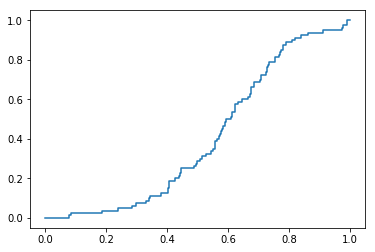

In [211]:
nn = n_downsamples*n_chunks
fpr,tpr,_ = mt.roc_curve(Y_data_gen_true.take(23,1) > 0,
                         Y_data_gen_pred.take(23,1))
plt.plot(fpr,tpr)

print(mt.auc(fpr,tpr))
print(roc_auc(Y_data_gen_true,Y_data_gen_pred))

In [10]:
Y_data_data_true = Y_data_data_true.reshape(-1, n_subjects)
Y_data_data_pred = Y_data_data_pred.reshape(-1, n_subjects)
C_data_data = mt.confusion_matrix(Y_data_data_true.argmax(axis=1), Y_data_data_pred.argmax(axis=1))

Y_data_gen_true = Y_data_gen_true.reshape(-1, n_subjects)
Y_data_gen_pred = Y_data_gen_pred.reshape(-1, n_subjects)
C_data_gen = mt.confusion_matrix(Y_data_gen_true.argmax(axis=1), Y_data_gen_pred.argmax(axis=1))

Y_data_all_true = Y_data_all_true.reshape(-1, n_subjects)
Y_data_all_pred = Y_data_all_pred.reshape(-1, n_subjects)
C_data_all = mt.confusion_matrix(Y_data_all_true.argmax(axis=1), Y_data_all_pred.argmax(axis=1))

Y_gen_data_true = Y_gen_data_true.reshape(-1, n_subjects)
Y_gen_data_pred = Y_gen_data_pred.reshape(-1, n_subjects)
C_gen_data = mt.confusion_matrix(Y_gen_data_true.argmax(axis=1), Y_gen_data_pred.argmax(axis=1))

Y_gen_gen_true = Y_gen_gen_true.reshape(-1, n_subjects)
Y_gen_gen_pred = Y_gen_gen_pred.reshape(-1, n_subjects)
C_gen_gen = mt.confusion_matrix(Y_gen_gen_true.argmax(axis=1), Y_gen_gen_pred.argmax(axis=1))

Y_gen_all_true = Y_gen_all_true.reshape(-1, n_subjects)
Y_gen_all_pred = Y_gen_all_pred.reshape(-1, n_subjects)
C_gen_all = mt.confusion_matrix(Y_gen_all_true.argmax(axis=1), Y_gen_all_pred.argmax(axis=1))

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    #tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else '.0f'
    #thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #lbl = format(cm[i, j], fmt)
        #if cm[i, j] > 0.01:
        #    plt.text(j, i, lbl,
        #         horizontalalignment="center",
        #         color="white" if cm[i, j] > thresh else "black")

    #plt.ylabel('True label')
    #plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix


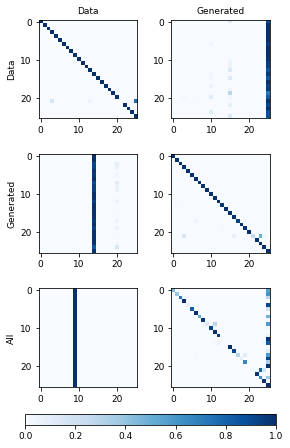

In [12]:
fig = plt.figure(figsize=(4,6))
fontsiz = 9

ax = plt.subplot(321)
plot_confusion_matrix(C_data_data, subjects, normalize=True, cmap=plt.cm.Blues)
for tl in ax.get_yticklabels():
    tl.set_fontsize(fontsiz)
for tl in ax.get_xticklabels():
    tl.set_fontsize(fontsiz)
plt.title('Data', fontsize=fontsiz)
ax.set_ylabel('Data')
ax.yaxis.get_label().set_fontsize(fontsiz)

ax = plt.subplot(322)
plot_confusion_matrix(C_gen_data, subjects, normalize=True, cmap=plt.cm.Blues)
for tl in ax.get_yticklabels():
    tl.set_fontsize(fontsiz)
for tl in ax.get_xticklabels():
    tl.set_fontsize(fontsiz)
plt.title('Generated', fontsize=fontsiz)

ax = plt.subplot(323)
plot_confusion_matrix(C_data_gen, subjects, normalize=True, cmap=plt.cm.Blues)
for tl in ax.get_yticklabels():
    tl.set_fontsize(fontsiz)
for tl in ax.get_xticklabels():
    tl.set_fontsize(fontsiz)
ax.set_ylabel('Generated', fontsize=fontsiz)

ax = plt.subplot(324)
plot_confusion_matrix(C_gen_gen, subjects, normalize=True, cmap=plt.cm.Blues)
for tl in ax.get_yticklabels():
    tl.set_fontsize(fontsiz)
for tl in ax.get_xticklabels():
    tl.set_fontsize(fontsiz)

ax = plt.subplot(325)
plot_confusion_matrix(C_data_all, subjects, normalize=True, cmap=plt.cm.Blues)
for tl in ax.get_yticklabels():
    tl.set_fontsize(fontsiz)
for tl in ax.get_xticklabels():
    tl.set_fontsize(fontsiz)
ax.set_ylabel('All', fontsize=fontsiz)

ax = plt.subplot(326)
plot_confusion_matrix(C_gen_all, subjects, normalize=True, cmap=plt.cm.Blues)
for tl in ax.get_yticklabels():
    tl.set_fontsize(fontsiz)
for tl in ax.get_xticklabels():
    tl.set_fontsize(fontsiz)
    
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.1, 0.0, 0.87, 0.025])
cb = plt.colorbar(cax=cbar_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=fontsiz)

plt.savefig('conf-mats.pdf', bbox_inches='tight')

In [213]:
auc = [
    roc_auc(Y_data_data_true, Y_data_data_pred),
    roc_auc(Y_data_gen_true, Y_data_gen_pred),
    roc_auc(Y_data_all_true, Y_data_all_pred),
    roc_auc(Y_gen_data_true, Y_gen_data_pred),
    roc_auc(Y_gen_gen_true, Y_gen_gen_pred),
    roc_auc(Y_gen_all_true, Y_gen_all_pred)
]

f1 = [
    mt.f1_score(Y_data_data_true.argmax(axis=1), Y_data_data_pred.argmax(axis=1), average='macro'),
    mt.f1_score(Y_data_gen_true.argmax(axis=1), Y_data_gen_pred.argmax(axis=1), average='macro'),
    mt.f1_score(Y_data_all_true.argmax(axis=1), Y_data_all_pred.argmax(axis=1), average='macro'),
    mt.f1_score(Y_gen_data_true.argmax(axis=1), Y_gen_data_pred.argmax(axis=1), average='macro'),
    mt.f1_score(Y_gen_gen_true.argmax(axis=1), Y_gen_gen_pred.argmax(axis=1), average='macro'),
    mt.f1_score(Y_gen_all_true.argmax(axis=1), Y_gen_all_pred.argmax(axis=1), average='macro')
]

acc = [
    mt.accuracy_score(Y_data_data_true.argmax(axis=1), Y_data_data_pred.argmax(axis=1)),
    mt.accuracy_score(Y_data_gen_true.argmax(axis=1), Y_data_gen_pred.argmax(axis=1)),
    mt.accuracy_score(Y_data_all_true.argmax(axis=1), Y_data_all_pred.argmax(axis=1)),
    mt.accuracy_score(Y_gen_data_true.argmax(axis=1), Y_gen_data_pred.argmax(axis=1)),
    mt.accuracy_score(Y_gen_gen_true.argmax(axis=1), Y_gen_gen_pred.argmax(axis=1)),
    mt.accuracy_score(Y_gen_all_true.argmax(axis=1), Y_gen_all_pred.argmax(axis=1))
]

score_names = ['AUC', 'F1', 'Val. acc.']

print(' \\\\\n'.join(
    [score_names[i] + ' & ' + ' & '.join(
        ['%.2f' % s for s in scores]) for i, scores in enumerate([auc, f1, acc])]))

AUC & 1.00 & 0.50 & 0.92 & 0.47 & 1.00 & 0.99 \\
F1 & 0.95 & 0.00 & 0.00 & 0.01 & 0.96 & 0.62 \\
Val. acc. & 0.96 & 0.04 & 0.04 & 0.04 & 0.97 & 0.61


/zhome/9d/d/98006/Documents/derp-project/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
h_size = 1000
n_try = 100
subjects = list(dataset.subjects())
prefix_length = 50

qn = sn_data.qn

traj = np.array([[i,0] for i in range(prefix_length)])
spline = Spline(traj, closed=False)
spline = pace_net.predict(spline, average_speed=0.5)
# Magic fix for direction
spline.tracks['direction'][0][:,0] = 1
spline.tracks['direction'][0][:,1] = 1

H_data = np.zeros((h_size, n_try, len(dataset.subjects())))
H_gen = np.zeros((h_size, n_try, len(dataset.subjects())))

for si, subject in enumerate(dataset.subjects()):
    print(subject)
    action = 'walking_2_d%d' % (np.random.randint(8))
    data = dataset[subject][action]['rotations']
    start_idx_subject = np.random.randint(data.shape[0] - n_try - prefix_length)
    for t in range(n_try):
        start_idx = t + start_idx_subject
        chunk_dat = torch.from_numpy(data[start_idx:(start_idx+prefix_length)])\
            .reshape(prefix_length, -1).float().unsqueeze(0)
        action_prefix = {}
        for key, arr in dataset[subject][action].items():
            action_prefix[key] = arr[start_idx:start_idx+prefix_length]
        _, chunk_gen = gen_net.generate_motion(spline, action_prefix, do_print=False, only_rotations=False)
        chunk_gen = chunk_gen.squeeze()[:prefix_length]
        chunk_gen = chunk_gen.reshape(prefix_length, -1).float().unsqueeze(0)        
        with torch.no_grad():
            H_data[:,t,si] = qn(chunk_dat.cuda())[1][1]
            H_gen[:,t,si] = qn(chunk_gen.cuda())[1][1]
print('Done')

Subject1
Subject2
Subject3
Subject4
Subject5
Subject6
Subject7
Subject8
Subject9
Subject10
Subject11
Subject12
Subject13
Subject14
Subject15
Subject16
Subject17
Subject18
Subject19
Subject20
Subject21
Subject22
Subject23
Subject24
Subject25
Subject26
Done


In [14]:
H_all.shape

NameError: name 'H_all' is not defined

In [15]:
pca_data = PCA()
pca_gen = PCA()
pca_all = PCA()

H_data_n = H_data.reshape(h_size, -1)
H_data_n /= np.linalg.norm(H_data_n, axis=0)
H_data_pca = pca_data.fit_transform(H_data_n.T).T.reshape(1000,n_try,-1)

H_gen_n = H_gen.reshape(h_size, -1)
H_gen_n /= np.linalg.norm(H_gen_n, axis=0)
H_gen_pca = pca_gen.fit_transform(H_gen_n.T).T.reshape(1000,n_try,-1)

H_all = np.hstack([H_data.reshape(h_size, -1) - np.mean(H_data.reshape(h_size, -1),axis=0), 
                   H_gen.reshape(h_size, -1) - np.mean(H_gen.reshape(h_size, -1), axis=0)])
H_all /= np.linalg.norm(H_all, axis=0)
H_all_pca = pca_all.fit_transform(H_all.reshape(h_size, -1).T).T.reshape(1000,-1,26)

In [117]:
ll = lines[0][0]
ll.get_color()

'#1f77b4'

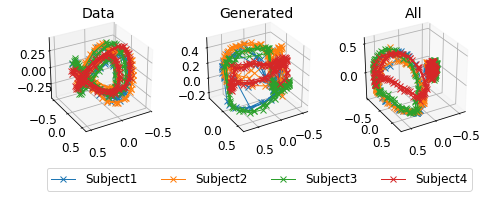

In [18]:
to_plot = [0,1,2,3]

%matplotlib inline
fig = plt.figure(figsize=(8,3))

plt.subplots_adjust(bottom=0.3)

fontsiz = 12

ax = plt.subplot(1,3,1, projection='3d')
for s in to_plot:
    plt.plot(H_data_pca[0,:,s].squeeze(),H_data_pca[1,:,s].squeeze(),H_data_pca[2,:,s].squeeze(),'x-',linewidth=1)
ax.view_init(30,60)
plt.title('Data', fontsize=fontsiz+2)
plt.xticks([-0.5,0,0.5])
for tx, ty, tz in zip(ax.get_xticklabels(), ax.get_yticklabels(), ax.get_zticklabels()):
    tx.set_fontsize(fontsiz)
    ty.set_fontsize(fontsiz)
    tz.set_fontsize(fontsiz)

ax = plt.subplot(1,3,2, projection='3d')
for s in to_plot:
    plt.plot(H_gen_pca[0,:,s].squeeze(),H_gen_pca[1,:,s].squeeze(),H_gen_pca[2,:,s].squeeze(),'x-',linewidth=1)
ax.view_init(30,60)
plt.title('Generated', fontsize=fontsiz+2)
for tx, ty, tz in zip(ax.get_xticklabels(), ax.get_yticklabels(), ax.get_zticklabels()):
    tx.set_fontsize(fontsiz)
    ty.set_fontsize(fontsiz)
    tz.set_fontsize(fontsiz)

ax = plt.subplot(1,3,3, projection='3d')
lines = []
for s in to_plot:
    lines.append(plt.plot(H_all_pca[0,:n_try,s].squeeze(),
                          H_all_pca[1,:n_try,s].squeeze(),
                          H_all_pca[2,:n_try,s].squeeze(),'x-',linewidth=1)[0])
for lp, s in zip(lines, to_plot):
    plt.plot(H_all_pca[0,n_try:,s].squeeze(),H_all_pca[1,n_try:,s].squeeze(),H_all_pca[2,n_try:,s].squeeze(),'x-',
            color=lp.get_color(), linewidth=1)
ax.view_init(30,60)
plt.title('All', fontsize=fontsiz+2)
for tx, ty, tz in zip(ax.get_xticklabels(), ax.get_yticklabels(), ax.get_zticklabels()):
    tx.set_fontsize(fontsiz)
    ty.set_fontsize(fontsiz)
    tz.set_fontsize(fontsiz)

plt.figlegend(lines, ['Subject%d' % (s + 1) for s in to_plot], 'lower center', ncol=4, bbox_to_anchor=(0.45,0.02), 
              fontsize=fontsiz)
#plt.tight_layout()
plt.savefig('pca-hidden.pdf', bbox_inches='tight')

In [89]:
np.linalg.norm(np.hstack([H_data.reshape(h_size, -1), H_gen.reshape(h_size, -1)]), axis=0)

array([1., 1., 1., ..., 1., 1., 1.])

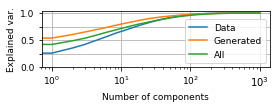

In [122]:
%matplotlib inline
fig = plt.figure(figsize=(4,1.6))
plt.semilogx(np.cumsum(pca_data.explained_variance_ratio_[:]))
plt.semilogx(np.cumsum(pca_gen.explained_variance_ratio_[:]))
plt.semilogx(np.cumsum(pca_all.explained_variance_ratio_[:]))
plt.grid()

plt.yticks([0.0,0.25,0.5,0.75,1.0])

ax = plt.gca()
ax.set_yticklabels(['0.0','','0.5','','1.0'])
for tx, ty in zip(ax.get_xticklabels(), ax.get_yticklabels()):
    tx.set_fontsize(9)
    ty.set_fontsize(9)
plt.xlabel('Number of components', fontsize=9)
plt.ylabel('Explained var.', fontsize=9)

plt.legend(['Data','Generated','All'], fontsize=9, loc='lower right', ncol=1)

plt.tight_layout()

plt.savefig('pca-explained-var.pdf', transparent=True)